# 0. Install Dependencies and Bring in Data

In [10]:
# !pip install tensorflow tensorflow-gpu pandas matplotlib sklearn

Defaulting to user installation because normal site-packages is not writeable
  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'


  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [44 lines of output]
      Traceback (most recent call last):
        File "C:\ProgramData\anaconda3\Lib\site-packages\setuptools\_vendor\packaging\requirements.py", line 35, in __init__
          parsed = _parse_requirement(requirement_string)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        File "C:\ProgramData\anaconda3\Lib\site-packages\setuptools\_vendor\packaging\_parser.py", line 64, in parse_requirement
          return _parse_requirement(Tokenizer(source, rules=DEFAULT_RULES))
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        File "C:\ProgramData\anaconda3\Lib\site-packages\setuptools\_vendor\packaging\_parser.py", line 82, in _parse_requirement
          url, specifier, marker = _parse_requirement_details(tokenizer)
                                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        File "C:\Prog

In [1]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

In [2]:
df = pd.read_csv(os.path.join('jigsaw-toxic-comment-classification-challenge','train.csv', 'train.csv'))

In [13]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


# 1. Preprocess

In [3]:
from tensorflow.keras.layers import TextVectorization

In [4]:
X = df['comment_text']
y = df[df.columns[2:]].values

In [5]:
MAX_FEATURES = 200000 # number of words in the vocab

In [6]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=50,
                               output_mode='int')

In [7]:
vectorizer.adapt(X.values)

In [8]:
vectorized_text = vectorizer(X.values)

In [9]:
#MCSHBAP - map, chache, shuffle, batch, prefetch  from_tensor_slices, list_file
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8) # helps bottlenecks

In [10]:
# training testing split
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

# 2. Create Sequential Model

In [91]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [92]:
model = Sequential()
# Create the embedding layer 
model.add(Embedding(MAX_FEATURES+1, 32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final layer 
model.add(Dense(6, activation='sigmoid'))

In [93]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam', metrics=['accuracy'])


In [94]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 32)          6400032   
                                                                 
 bidirectional_2 (Bidirecti  (None, 64)                16640     
 onal)                                                           
                                                                 
 dense_8 (Dense)             (None, 128)               8320      
                                                                 
 dense_9 (Dense)             (None, 256)               33024     
                                                                 
 dense_10 (Dense)            (None, 128)               32896     
                                                                 
 dense_11 (Dense)            (None, 6)                 774       
                                                      

In [95]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(train, epochs=100, validation_data=val, callbacks=[early_stop])


Epoch 1/100
6981/6981 [==============================] - 617s 88ms/step - loss: 0.0628 - accuracy: 0.9864 - val_loss: 0.0471 - val_accuracy: 0.9939
Epoch 2/100
6981/6981 [==============================] - 630s 90ms/step - loss: 0.0471 - accuracy: 0.9688 - val_loss: 0.0400 - val_accuracy: 0.9921
Epoch 3/100
6981/6981 [==============================] - 636s 91ms/step - loss: 0.0417 - accuracy: 0.9890 - val_loss: 0.0354 - val_accuracy: 0.9939
Epoch 4/100
6981/6981 [==============================] - 630s 90ms/step - loss: 0.0362 - accuracy: 0.9935 - val_loss: 0.0321 - val_accuracy: 0.9932
Epoch 5/100
6981/6981 [==============================] - 590s 84ms/step - loss: 0.0326 - accuracy: 0.9802 - val_loss: 0.0283 - val_accuracy: 0.9945
Epoch 6/100
6981/6981 [==============================] - 603s 86ms/step - loss: 0.0294 - accuracy: 0.9828 - val_loss: 0.0241 - val_accuracy: 0.9942
Epoch 7/100
6981/6981 [==============================] - 635s 91ms/step - loss: 0.0263 - accuracy: 0.9921 - val_

In [96]:
import matplotlib.pyplot as plt


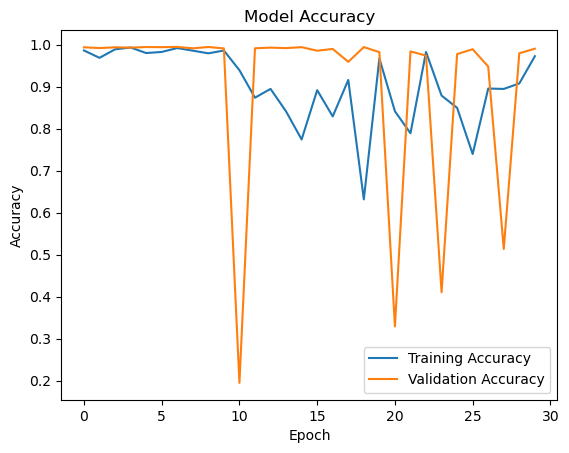

In [97]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# 3. Make Predictions

In [11]:
input_text = 'You freaking suck!'
vectorized_input = vectorizer([input_text])

In [15]:
res = model.predict(vectorized_input)

1/1 [==============================] - 1s 1s/step


In [100]:
print((res > 0.5).astype(int))

[[1 0 1 0 1 0]]


In [101]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [102]:
(model.predict(batch_X) > 0.5).astype(int)

1/1 [==============================] - 0s 25ms/step


array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

# 4. Evaluate Model

In [103]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [104]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [105]:
for batch in test.as_numpy_iterator(): 
    # Unpack the batch 
    X_true, y_true = batch
    # Make a prediction 
    yhat = model.predict(X_true)
    
    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()
    
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

1/1 [==============================] - 0s 21ms/step


In [106]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.983367383480072, Recall:0.9799360036849976, Accuracy:0.5406218767166138


# 5. Test and Gradio

In [107]:
# !pip install gradio --upgrade

In [12]:
import tensorflow as tf
import gradio as gr

In [109]:
model.save('toxicity_final.h5')

C:\Users\iamra\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [13]:
model = tf.keras.models.load_model('toxicity_final.h5')

In [23]:
input_str = vectorizer('hey i freaken hate you!')

In [24]:
res = model.predict(np.expand_dims(input_str,0))

1/1 [==============================] - 1s 887ms/step


In [25]:
res

array([[0.9381344 , 0.00488733, 0.0263121 , 0.00231311, 0.42879435,
        0.00485539]], dtype=float32)

In [14]:
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)
    
    text = ''
    for idx, col in enumerate(df.columns[2:]):
        text += '{}: {}\n'.format(col, results[0][idx]>0.5)
    
    return text

In [15]:
interface = gr.Interface(fn=score_comment, 
                        inputs=gr.Textbox(lines=2, placeholder='Comment to score'),
                        outputs='text')

In [16]:
interface.launch(share=True)

Running on local URL:  http://127.0.0.1:7860

Could not create share link. Please check your internet connection or our status page: https://status.gradio.app.


2024/05/10 09:28:51 [W] [service.go:132] login to server failed: EOF


1/1 [==============================] - 0s 49ms/step
